In [1]:
import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from config import *
from Data.raw_data_loader import load_raw_crypto_csv
from Models.zscore import zscore_signal
from Models.ou import ou_signal_on_spread
from Models.trend import trend_signal
from Models.mining import mining_signal
from Backtest.engine import run_backtest
from Backtest.metrics import build_summary_table, rolling_sharpe

plt.style.use("default")

In [2]:
df = load_raw_crypto_csv(DATA_PATH)

df = df[(df["BTC-USD_close"] > 0)]
df = df.loc["2016-01-01":].copy()

btc_ret = df["BTC-USD_close"].pct_change()
df = df[btc_ret.abs() < 1.0]   # remove extreme data errors

print("Shape:", df.shape)

Shape: (3689, 12)


In [3]:
z_pos = zscore_signal(df, price_column=PRICE_COLUMN_BTC)


In [4]:
z_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=z_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

In [5]:
ou_pos = ou_signal_on_spread(
    df["BTC-USD_close"],
    window=OU_WINDOW,
    entry_z=OU_ENTRY_Z,
    exit_z=OU_EXIT_Z,
)

NameError: name 'min_std' is not defined

In [ ]:
ou_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=ou_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

In [ ]:
trend_pos = trend_signal(
    df,
    price_column=PRICE_COLUMN_BTC,
    fast_window=TREND_FAST_WINDOW,
    slow_window=TREND_SLOW_WINDOW,
    long_only=TREND_LONG_ONLY,
    leverage_aggressive=TREND_AGGRESSIVE,
    leverage_neutral=TREND_NEUTRAL,
    leverage_defensive=TREND_DEFENSIVE,
)

In [ ]:
trend_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=trend_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

In [ ]:
mining_pos = mining_signal(
    df,
    z_window=MINING_Z_WINDOW,
    entry_z=MINING_ENTRY_Z,
    exit_z=MINING_EXIT_Z,
    use_log_edge=MINING_USE_LOG_EDGE,
)

In [ ]:
mining_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=mining_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

In [ ]:
summary = build_summary_table({
    "Z-Score": {
        "returns": z_results["net_returns"],
        "position": z_pos,
    },
    "OU": {
        "returns": ou_results["net_returns"],
        "position": ou_pos,
    },
    "Trend": {
        "returns": trend_results["net_returns"],
        "position": trend_pos,
    },
    "Mining": {
        "returns": mining_results["net_returns"],
        "position": mining_pos,
    },
})

summary

,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
Z-Score,1.021569,1.353331,0.229434,-0.386272,0.593970,0.232361,0.227456,3690,7.500838
OU,-1.083694,-1.403999,-0.610894,-0.999957,-0.610920,-0.720252,0.664626,3690,0.098916
Trend,1.181977,1.527869,0.827213,-0.854881,0.967635,0.892902,0.755431,3690,1.810163
Mining,1.199795,1.045219,0.535872,-0.426149,1.257475,0.524020,0.436758,3690,4.352304


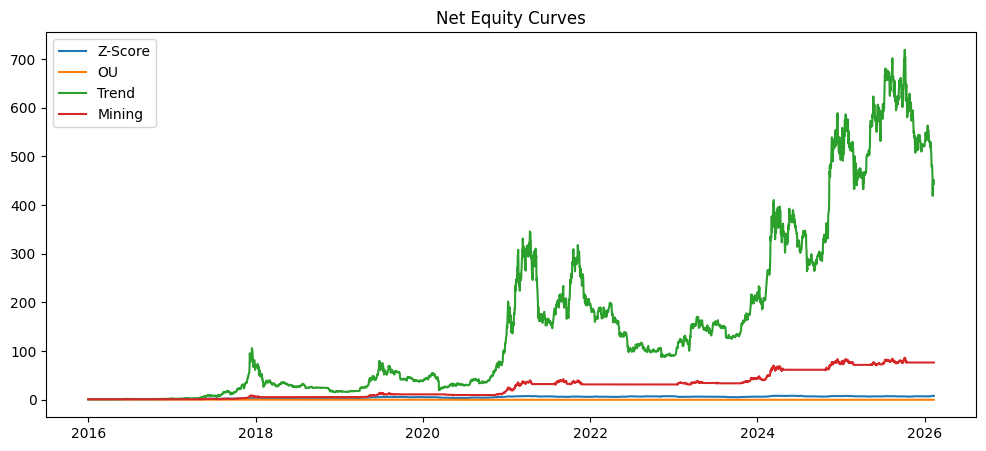

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(z_results["net_equity"], label="Z-Score")
plt.plot(ou_results["net_equity"], label="OU")
plt.plot(trend_results["net_equity"], label="Trend")
plt.plot(mining_results["net_equity"], label="Mining")
plt.title("Net Equity Curves")
plt.legend()
plt.show()

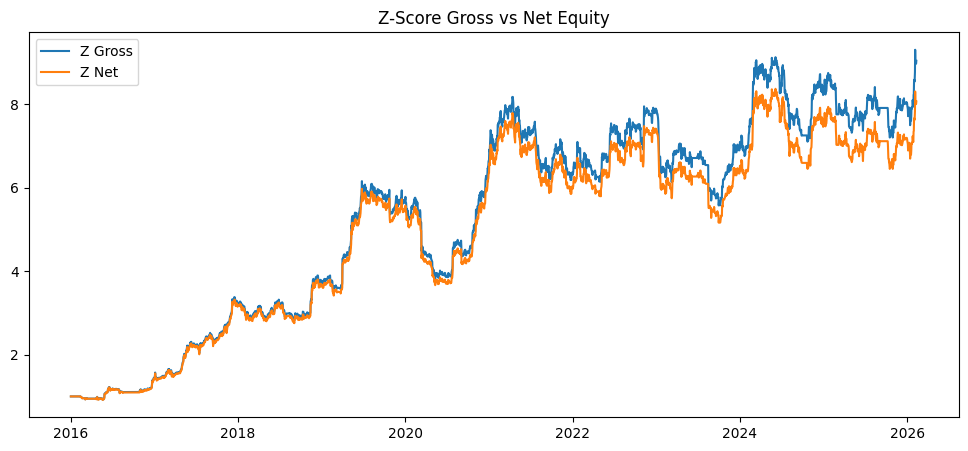

In [ ]:
z_gross = z_results["gross_equity"]
z_net = z_results["net_equity"]

plt.figure(figsize=(12,5))
plt.plot(z_gross, label="Z Gross")
plt.plot(z_net, label="Z Net")
plt.title("Z-Score Gross vs Net Equity")
plt.legend()
plt.show()

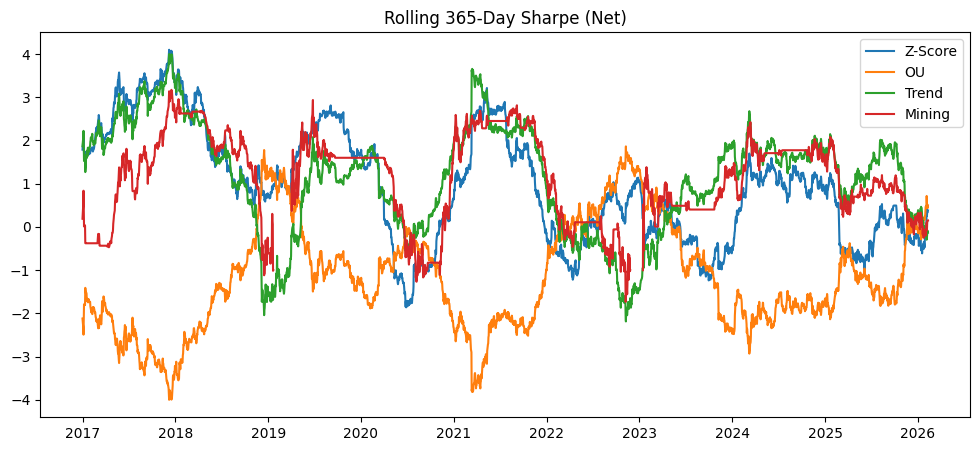

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(rolling_sharpe(z_results["net_returns"], window=365), label="Z-Score")
plt.plot(rolling_sharpe(ou_results["net_returns"], window=365), label="OU")
plt.plot(rolling_sharpe(trend_results["net_returns"], window=365), label="Trend")
plt.plot(rolling_sharpe(mining_results["net_returns"], window=365), label="Mining")
plt.title("Rolling 365-Day Sharpe (Net)")
plt.legend()
plt.show()

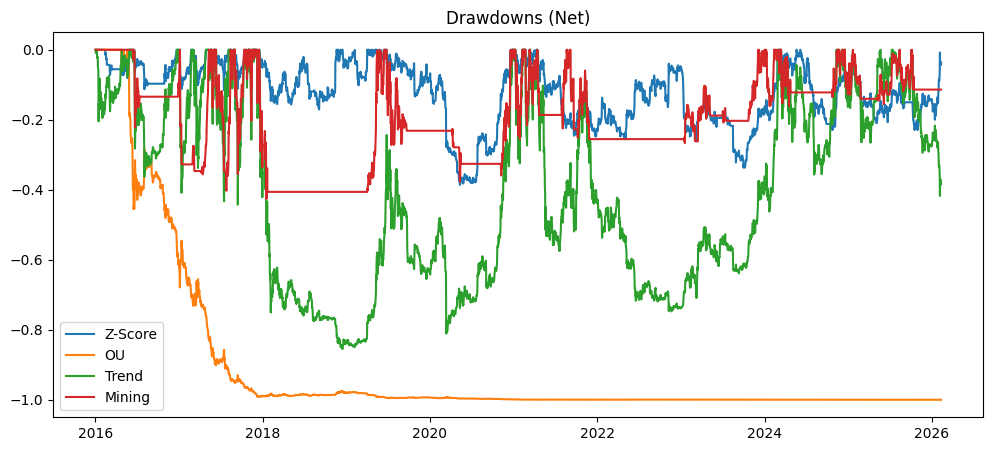

In [ ]:
def drawdown(equity: pd.Series) -> pd.Series:
    peak = equity.cummax()
    return equity / peak - 1.0

plt.figure(figsize=(12,5))
plt.plot(drawdown(z_results["net_equity"]), label="Z-Score")
plt.plot(drawdown(ou_results["net_equity"]), label="OU")
plt.plot(drawdown(trend_results["net_equity"]), label="Trend")
plt.plot(drawdown(mining_results["net_equity"]), label="Mining")
plt.title("Drawdowns (Net)")
plt.legend()
plt.show()

In [ ]:
def annual_turnover(pos: pd.Series) -> float:
    return float(pos.diff().abs().sum() / len(pos) * 365)

print("Annual Turnover Z:", annual_turnover(z_pos))
print("Annual Turnover OU:", annual_turnover(ou_pos))
print("Annual Turnover Trend:", annual_turnover(trend_pos))
print("Annual Turnover Mining:", annual_turnover(mining_pos))

Annual Turnover Z: 7.500837768228015
Annual Turnover OU: 0.0989159891598916
Annual Turnover Trend: 1.8101626016260168
Annual Turnover Mining: 4.35230352303523


In [ ]:
def backtest_with_costs(pos, fee_bps, slip_bps):
    return run_backtest(
        price_series=df["BTC-USD_close"],
        position=pos,
        fee_bps=fee_bps,
        slippage_bps=slip_bps,
        leverage_cap=LEVERAGE_CAP,
    )["net_returns"]

cost_cases = {
    "0 bps": (0.0, 0.0),
    "10 bps": (10.0, 0.0),
    "20 bps": (10.0, 10.0),
}

rows = []
for name, (fee, slip) in cost_cases.items():
    r = backtest_with_costs(z_pos, fee, slip)
    rows.append({"CostCase": name, **build_summary_table({"tmp": {"returns": r, "position": z_pos}}).iloc[0].to_dict()})

pd.DataFrame(rows).set_index("CostCase")

,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
CostCase,,,,,,,,,
0 bps,1.071542,1.416022,0.243370,-0.379546,0.641214,0.243613,0.227348,3690.0,7.500838
10 bps,1.038235,1.375641,0.234063,-0.384038,0.609479,0.236112,0.227417,3690.0,7.500838
20 bps,1.004895,1.331225,0.224821,-0.388498,0.578694,0.228611,0.227497,3690.0,7.500838
